<h1 align="center">NYC Taxi Fare And Duration Prediction</h1>

<h2><font>Data importing</font></h2>

In [1]:
#ucitavanje potrebnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calander

In [2]:
#ucitavanje podataka iz 2016.godine za mjesec maj
taxi_data=pd.read_parquet('yellow_tripdata_2016-05.parquet',engine='fastparquet')

<h2>Data Wrangling</h2>

<h3><font color="red">Podaci prije obrade</font></h3>

In [4]:
#ispis prvih pet redova 
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,NaN,NaN
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,NaN,NaN
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,N,166,238,2,5.5,0.5,0.5,0.0,0.00,0.3,6.80,NaN,NaN
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,N,151,74,2,11.0,0.5,0.5,0.0,0.00,0.3,12.30,NaN,NaN
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,N,74,129,2,15.5,0.5,0.5,0.0,5.54,0.3,22.34,NaN,NaN


In [5]:
#Ispis broja uzoraka i broja obilježja
print("Broj uzoraka:",taxi_data.shape[0],"\n")
print("Broj obilježja:",taxi_data.shape[1],"\n")
#Tipovi podataka svakog obilježja
taxi_data.dtypes


Broj uzoraka: 11832049 

Broj obilježja: 19 



VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

<h3><font color="blue">OBRADA</font></h3>

<h3>Izbacivanje nedostajucih podataka</h3>
Na osnovu prikaza iznad moze se primjetiti da su nedostajuci podaci prisutni u dva obiljezja (airport_fee, congestion_surcharge). Ukupan broj NaN podataka je jednak ukupnom broju uzoraka odnosno za ta obiljezje nemamo podata pa cemo ih izbaciti

In [5]:
#Provjera da li ima nedostajucih podataka 
null=taxi_data.isnull().sum().sort_values(ascending=False)
print("Nedostajući podaci po svakom obilježju:\n",null)

Nedostajući podaci po svakom obilježju:
 airport_fee              11832049
congestion_surcharge     11832049
fare_amount                     0
total_amount                    0
improvement_surcharge           0
tolls_amount                    0
tip_amount                      0
mta_tax                         0
extra                           0
VendorID                        0
tpep_pickup_datetime            0
DOLocationID                    0
PULocationID                    0
store_and_fwd_flag              0
RatecodeID                      0
trip_distance                   0
passenger_count                 0
tpep_dropoff_datetime           0
payment_type                    0
dtype: int64


In [6]:
#Izbacivanje kolona koje imaju sve NaN vrijednosti
taxi_data.drop(['airport_fee','congestion_surcharge'],inplace=True,axis=1)
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,N,166,238,2,5.5,0.5,0.5,0.0,0.00,0.3,6.80
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,N,151,74,2,11.0,0.5,0.5,0.0,0.00,0.3,12.30
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,N,74,129,2,15.5,0.5,0.5,0.0,5.54,0.3,22.34


<h3>Izbacivanje nerelevantnih obiljezja</h3>
Posto cemo vrsiti predikciju obiljezja fare_amount, a ne total_amount, obiljezja koja se odnose na dodatne troskove cemo izbaciti

In [7]:
#Izbacivanje obiljezja koja ne uticu direktno na fare_amout 
taxi_data.drop(['store_and_fwd_flag','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount'],inplace=True,axis=1)

In [8]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount'],
      dtype='object')

<h3>Transformacija postojecih i dodavanje novih obiljezja</h3>

In [9]:
# razlaganje datetime na posebna vremenska obiljezja
taxi_data['pickup_date']=taxi_data['tpep_pickup_datetime'].dt.date
taxi_data['pickup_time']=taxi_data['tpep_pickup_datetime'].dt.time
taxi_data['dropoff_date']=taxi_data['tpep_dropoff_datetime'].dt.date
taxi_data['dropoff_time']=taxi_data['tpep_dropoff_datetime'].dt.time
taxi_data['week_day']=taxi_data['tpep_pickup_datetime'].dt.dayofweek
taxi_data.loc[taxi_data['week_day']<5,'day_type']='workday'
taxi_data.loc[taxi_data['week_day']>=5,'day_type']='weekend'

In [10]:
taxi_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
pickup_date                      object
pickup_time                      object
dropoff_date                     object
dropoff_time                     object
week_day                          int64
day_type                         object
dtype: object

<h3>Ubacivanje praznika</h3>
Ako neki dan u datom skupu podataka je praznik, trebalo bi to oznaciti, jer moze da utice na voznje taj daj(zbog saobracaja mogu voznje biti duze/krace/jeftinije). Potrebno je sve voznje tog dana oznaciti da su u vrijeme praznika.

In [14]:
#dobavljanje praznika za 
cal = calander()
holidays_US = cal.holidays(start='2016-05-01', end='2016-05-31')
holidays_data=[]
for holiday in holidays_US:
    holidays_data.append(holiday.date())
holidays_data

[datetime.date(2016, 5, 30)]

In [15]:
#ispis praznika u 2016
import holidays
for ptr in holidays.US(years =2016 ).items():
    print(ptr)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2016, 2, 15), "Washington's Birthday")
(datetime.date(2016, 5, 30), 'Memorial Day')
(datetime.date(2016, 7, 4), 'Independence Day')
(datetime.date(2016, 9, 5), 'Labor Day')
(datetime.date(2016, 10, 10), 'Columbus Day')
(datetime.date(2016, 11, 11), 'Veterans Day')
(datetime.date(2016, 11, 24), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (Observed)')


In [18]:
#postavljanje tipa dana na praznik
taxi_data.loc[(taxi_data['pickup_date'].isin(holidays_data)) == True, 'day_type'] = "holiday"

In [19]:
taxi_data.groupby(by='day_type')['VendorID'].count()

day_type
holiday     261093
weekend    3465027
workday    8105929
Name: VendorID, dtype: int64

<h3>Ubacivanje u kom dijelu dana je bila svaka voznja</h3>

<h4><font color="green">FUNCKIJA - za definisanje dijela dana na osnovu sata</font></h4>
<hr>

In [36]:
def day_time_slots(x):
    if x in range(5,9):
        return 'Early Morning'
    elif x in range(9,13):
        return 'Late Morning'
    elif x in range(13,16):
        return 'Early Afternoon'
    elif x in range(16,19):
        return 'Late Afternoon'
    elif x in range(19,22):
        return 'Evening'
    else:
        return 'Night'

<hr>

In [40]:
#dodavanje obiljezja za dio dana
taxi_data['day_time_slot'] = (taxi_data['tpep_pickup_datetime'].dt.hour).apply(day_time_slots)

In [41]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,145,145,2,2.5,2016-05-01,00:07:41,2016-05-01,00:08:25,6,weekend,Night
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,145,145,2,2.5,2016-05-01,00:09:08,2016-05-01,00:09:58,6,weekend,Night
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,166,238,2,5.5,2016-05-01,00:01:47,2016-05-01,00:05:27,6,weekend,Night
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,151,74,2,11.0,2016-05-01,00:11:46,2016-05-01,00:25:35,6,weekend,Night
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,74,129,2,15.5,2016-05-01,00:30:45,2016-05-01,00:40:08,6,weekend,Night


<h3>Dodavanje obiljezja za trajanje voznje u minutama</h3>

In [42]:
#dodavanje obiljezja za trajanje voznje u minutama
taxi_data['duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']
taxi_data['duration'] = taxi_data['duration'] / np.timedelta64(1, 'm')
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot,duration
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,145,145,2,2.5,2016-05-01,00:07:41,2016-05-01,00:08:25,6,weekend,Night,0.733333
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,145,145,2,2.5,2016-05-01,00:09:08,2016-05-01,00:09:58,6,weekend,Night,0.833333
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,166,238,2,5.5,2016-05-01,00:01:47,2016-05-01,00:05:27,6,weekend,Night,3.666667
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,151,74,2,11.0,2016-05-01,00:11:46,2016-05-01,00:25:35,6,weekend,Night,13.816667
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,74,129,2,15.5,2016-05-01,00:30:45,2016-05-01,00:40:08,6,weekend,Night,9.383333


<h3>Pretvaranje milja u kilometre</h3>

In [43]:
#pretvaranje miles to km
taxi_data['trip_distance']=taxi_data['trip_distance']*1.609

#izracunavanje prosjecne brzine na osnovu predjenog puta i trajanje voznje u km/h
taxi_data['avg_speed']=taxi_data['trip_distance']/(taxi_data['duration']/60)

In [44]:
taxi_data['trip_distance'].max()

19308007.2405

<h3>Izbacivanje pocetnih obiljezja sa datumom i vremenom</h3>

In [45]:
#Izbacivanje pocetna obiljezja sa datumom i vremenom
taxi_data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1, inplace=True)

In [47]:
taxi_data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time',
       'week_day', 'day_type', 'day_time_slot', 'duration', 'avg_speed'],
      dtype='object')

<h3><font color="brown">Sacuvavanje dataframe-a nakon Data Wrangling</font></h3>

In [48]:
taxi_data.to_parquet('yellow_tripdata_2016-05_AFTER_WRANGLING.parquet')

## Features analysis

<h3>Import poslije data wrangling</h3>

In [49]:
taxi_data=pd.read_parquet('yellow_tripdata_2016-05_AFTER_WRANGLING.parquet',engine='fastparquet')

<h3>Kategoricka obiljezja</h3>

In [50]:
#Ispis vrijednosti za kategoricka obiljezja 
print('RatecodeID values:',taxi_data['RatecodeID'].unique())
print('Passenger_count values:',taxi_data['passenger_count'].unique())
print('Payment_type values:',taxi_data['payment_type'].unique())
print('Week_day values:',taxi_data['week_day'].unique())
print('Day_type values:',taxi_data['day_type'].unique())
print('Day_time_slot values:',taxi_data['day_time_slot'].unique())

RatecodeID values: [ 1  2  5  3  4  6 99]
Passenger_count values: [1 2 3 4 6 5 0 8 7 9]
Payment_type values: [2 1 3 4 5]
Week_day values: [6 0 1 2 3 4 5]
Day_type values: ['weekend' 'workday' 'holiday']
Day_time_slot values: ['Night' 'Early Morning' 'Late Morning' 'Early Afternoon' 'Late Afternoon'
 'Evening']


Na osnovu vrijednosti koje su izlistane iznad, moze se uociti da za ratecodeID postoji jedna nevalidna vrijednost=99. Takodje nema smisla da se gledaju voznje gdje je broj putnika 0.

In [51]:
print('Broj voznji sa nevalidnim RatecodeId:',taxi_data[taxi_data['RatecodeID']==99]['RatecodeID'].count())
print('Broj voznji sa 0 putnika:',taxi_data[taxi_data['passenger_count']==0]['passenger_count'].count())

Broj voznji sa nevalidnim RatecodeId: 362
Broj voznji sa 0 putnika: 602


In [52]:
#uklanjanje nevalidnih voznji za RatecodeID i passenger_count
taxi_data=taxi_data[(taxi_data['RatecodeID']!=99) & (taxi_data['passenger_count']!=0)]

<h3>Numericka obiljezja</h3>

In [53]:
#statistika za numericka obiljezja
taxi_data[['trip_distance','fare_amount','duration','avg_speed']].describe()

,trip_distance,fare_amount,duration,avg_speed
count,1.183117e+07,1.183117e+07,1.183117e+07,1.181964e+07
mean,9.835516e+00,1.334207e+01,1.667657e+01,inf
std,8.296648e+03,1.174657e+01,1.173282e+02,NaN
min,0.000000e+00,-4.100000e+02,-1.364710e+05,-4.054680e+03
25%,1.609000e+00,6.500000e+00,6.783333e+00,1.201743e+01
50%,2.767480e+00,9.500000e+00,1.146667e+01,1.658481e+01
75%,5.261430e+00,1.500000e+01,1.885000e+01,2.269995e+01
max,1.930801e+07,8.007000e+03,1.009343e+04,inf


In [55]:
print('Broj voznji sa rastojanjem 0:',taxi_data[taxi_data['trip_distance']==0]['trip_distance'].count())
print('Broj voznji sa trajanjem <= 0:',taxi_data[taxi_data['duration']<=0]['duration'].count())
print('Broj voznji sa cijenom <= 0:',taxi_data[taxi_data['fare_amount']<=0]['fare_amount'].count())

Broj voznji sa rastojanjem 0: 67396
Broj voznji sa trajanjem <= 0: 11921
Broj voznji sa cijenom <= 0: 7928


Na osnovu statistickih vrijednosti, primjecuju se odredjena odstupanja :
<li> Minimalna vrijednsot za duzinu puta je 0 (67396 uzoraka)</li>
<li> Minimalna vrijednost za trajanje je negativna </li>
<li> Postoje voznje sa negativnom cijenom </li>

In [56]:
#uklanjanje voznji sa nevalidnim podacima 
taxi_data=taxi_data[ (taxi_data['trip_distance']!=0) & (taxi_data['duration']>0) & (taxi_data['fare_amount']>0)]

In [57]:
print('Broj voznji sa rastojanjem 0:',taxi_data[taxi_data['trip_distance']==0]['trip_distance'].count())
print('Broj voznji sa trajanjem <= 0:',taxi_data[taxi_data['duration']<=0]['duration'].count())
print('Broj voznji sa cijenom <= 0:',taxi_data[taxi_data['fare_amount']<=0]['fare_amount'].count())

Broj voznji sa rastojanjem 0: 0
Broj voznji sa trajanjem <= 0: 0
Broj voznji sa cijenom <= 0: 0


In [59]:
#statistika numerickih obiljezja nakon izbacivanja nevalidnih vrijednosti
taxi_data[['trip_distance','fare_amount','duration','avg_speed']].describe()

,trip_distance,fare_amount,duration,avg_speed
count,1.175745e+07,1.175745e+07,1.175745e+07,1.175745e+07
mean,9.893916e+00,1.330569e+01,1.684082e+01,2.374125e+02
std,8.322616e+03,1.143628e+01,5.485302e+01,5.139559e+05
min,1.609000e-02,1.000000e-02,1.666667e-02,6.708049e-04
25%,1.641180e+00,6.500000e+00,6.850000e+00,1.208592e+01
50%,2.799660e+00,9.500000e+00,1.151667e+01,1.662890e+01
75%,5.309700e+00,1.500000e+01,1.891667e+01,2.273652e+01
max,1.930801e+07,8.007000e+03,1.009343e+04,1.616435e+09


### Passenger count

In [61]:
#broj uzoraka po broju putnika u taksiju tokom jedne voznje
passenger_counts=taxi_data.groupby(['passenger_count']).count()
passenger_counts['VendorID']

passenger_count
1    8295092
2    1730042
3     498464
4     232500
5     623444
6     377878
7         12
8          5
9         15
Name: VendorID, dtype: int64

In [62]:
#broj putnika izrazen u procentima
passenger_counts['VendorID']/(passenger_counts['VendorID'].sum())*100

passenger_count
1    70.551783
2    14.714430
3     4.239558
4     1.977469
5     5.302543
6     3.213945
7     0.000102
8     0.000043
9     0.000128
Name: VendorID, dtype: float64

C:\Users\Srdjan Topic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

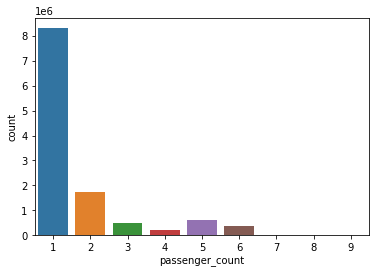

In [63]:
sb.countplot(taxi_data["passenger_count"])

Na osnovu prikazanog dijagrama, moze se uociti da je vecina voznji bila sa jednim putnikom i to cak 70,5%. Voznji sa dva putnika je 14.7%, dok su ostale vrijdednosti jako male. 
Vidi se da postoje voznje sa cak 9 putnika. Za brojeve putnika vece od 6 procenti su manji od 0.0002.

In [64]:
#uporedjivanje broja putnika sa predjenim putem i cijenom prevoza 
taxi_data.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()

C:\Users\SRDJAN~1\AppData\Local\Temp/ipykernel_584/1834321843.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  taxi_data.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()


,trip_distance,fare_amount
passenger_count,,
1,10.444757,13.098225
2,12.052338,14.059720
3,5.118922,13.680084
4,5.195834,13.840389
5,5.128689,13.502563
6,4.970715,13.256759
7,11.529826,34.318333
8,23.690916,83.000000
9,20.054576,57.820000


Za voznje sa brojem putnika do 6, vidimo da obicno prelaze slicne distance i cijena je slicna, dok se za broj putnika od 7 cijena drasticno povecava, cak se i prelaze duze staze.


S obzirom na istrazivanja na internetu, iako je po zakonu zabranjeno da se u obicnom taksiju vozi vise od 4 osobe, postoje vozila koja imaju veci broj sjedista za cak 8 osoba, tako da voznje sa velikim brojem putnika iako ih je jako malo nece biti izbacene

<h4><font color="green">FUNCKIJA - za iscrtavanje histograma i boxplot-a</font></h4>
<hr>

In [77]:
def data_distribution(data, label):
   
    x = np.array(data)
    
    fig = plt.figure()
    
    # histogram
    ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])
    ax1 = plt.hist(x, bins=30)
    plt.grid(alpha=.5)
    
    # boxplot
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
    ax2 = plt.boxplot(x, vert=False, widths=0.7)
    plt.grid(alpha=.5)
           
    plt.show()

<h3>avg_speed</h3>

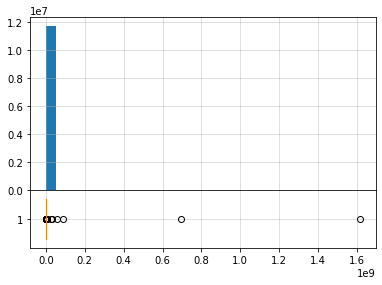

In [65]:
data_distribution(taxi_data['avg_speed'],'avg_speed')

Posto se vidi da imamo ocigledne outliere za brzinu koja je u km/hm te outliere cemo izbaciti. Izbacicemo sve brzine koje su >=100km/h

In [66]:
taxi_data=taxi_data[taxi_data['avg_speed']<100]

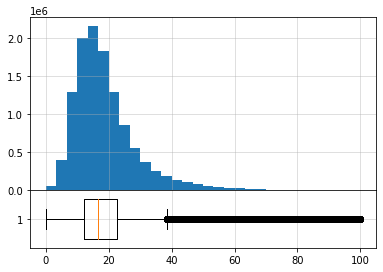

In [67]:
data_distribution(taxi_data['avg_speed'],'avg_speed')

Moze se primjetiti da je raspon prosjecne brzine 0-20km/h. To djeluje sporo, ali kada se takodje uracuna i saobracaj i duzina trajanja voznje, zapravo ne zvuci nerealno.

In [68]:
taxi_data['avg_speed'].describe()

count    1.174614e+07
mean     1.875856e+01
std      1.001432e+01
min      6.708049e-04
25%      1.208075e+01
50%      1.662095e+01
75%      2.271529e+01
max      9.992995e+01
Name: avg_speed, dtype: float64

In [69]:
print('Broj voznji sa prosjecnom brzinom >24km/h:',taxi_data[taxi_data['avg_speed']> 24]['avg_speed'].count())
print('Broj voznji sa prosjecnom brzinom <=24km/h:',taxi_data[taxi_data['avg_speed']<=24]['avg_speed'].count())

Broj voznji sa prosjecnom brzinom >24km/h: 2533152
Broj voznji sa prosjecnom brzinom <=24km/h: 9212986


<h3> Trip_distance </h3>

In [70]:
taxi_data["trip_distance"].describe()

count    1.174614e+07
mean     4.943472e+00
std      6.051340e+00
min      1.609000e-02
25%      1.641180e+00
50%      2.799660e+00
75%      5.309700e+00
max      4.143175e+02
Name: trip_distance, dtype: float64

##### Prije izvrsavanja izbacivanja avg_speed>100km/h statistika za trip_distance je bila:
max: 19 308 000km <br>
srednja vrijednost: 9.89km a <br>
medijan: 2.79km <br> 
sto znaci da postoje autlajeri koji znantno veci od prosjecne duzine puta
##### Dok nakon izvrsavanja svi ti outlier-i sto su bili su nestali i skup sada ima realnije podatke i vrijednosti

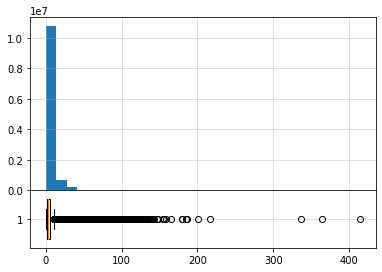

In [71]:
#raspodjela vrijednosti za trip_distance
data_distribution(taxi_data['trip_distance'],'trip_distance')

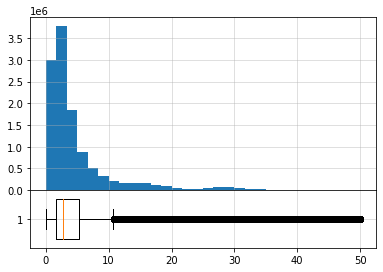

In [72]:
data_distribution(taxi_data['trip_distance'][taxi_data["trip_distance"] <= 50],'trip_distance')

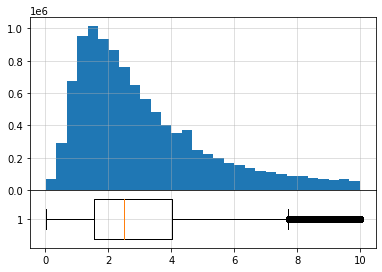

In [73]:
data_distribution(taxi_data['trip_distance'][taxi_data["trip_distance"] <= 10],'trip_distance')

Na osnovu prethodne 3 distribucije se moze primjetiti da vecina voznji imaju duzinu predjenog puta 1-6 kilometara.

### Duration

In [76]:
taxi_data["duration"].describe()

count    1.174614e+07
mean     1.685610e+01
std      5.487696e+01
min      1.666667e-02
25%      6.866667e+00
50%      1.153333e+01
75%      1.893333e+01
max      1.009343e+04
Name: duration, dtype: float64

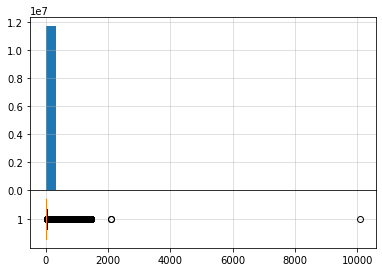

In [78]:
data_distribution(taxi_data['duration'],'duration')

##### Moze se primjetiti ocigledan outlier koji ce se izbaciti
Takodje i sve vrijednosti duzine trajanja koje su vece od 3000min (50h) ce biti izbacene

In [79]:
#izbacivanje outliera za duration>=3000min (50h)
taxi_data=taxi_data[taxi_data['duration']<3000]

In [80]:
taxi_data["duration"].describe()

count    1.174614e+07
mean     1.685524e+01
std      5.479815e+01
min      1.666667e-02
25%      6.866667e+00
50%      1.153333e+01
75%      1.893333e+01
max      2.098233e+03
Name: duration, dtype: float64

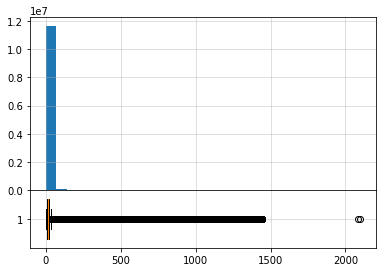

In [81]:
data_distribution(taxi_data['duration'],'duration')

##### I dalje postoje outlier-i
Te se i te vrijednosti izbacuju

In [83]:
taxi_data=taxi_data[taxi_data['duration']<1500]

<h3>Kombinacija duration i trip_distance </h3>

<h4><font color="green">FUNCKIJA - za iscrtavanje scatter plota</font></h4>
<hr>

In [84]:
def scatter_plot(x_data, y_data, x_label, y_label):
   
    x = np.array(x_data)
    y = np.array(y_data)
    
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

<hr>

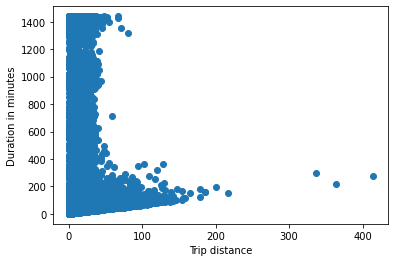

In [85]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

##### Realna situacijia na ovom scatter plot-u bi bila da kako raste razdaljina tako i vrijeme trajanja prevoza

Tri tacke koje se nalaze skroz desno jedu realne vrijednosti kombinacije ovih obiljezja, jer njujork sam po sebi je
dugacak oko 530km a sirok oko 455km. Takodje nije ni nerealno preci toliku razdaljinu za oko 5-7 sati, pogotovo ako se prevoz krece autoputom.

Zato sa druge strane nerealna predstava je bilo koja kombinacija trajanja koja je vezana za skoro 0km predjenih

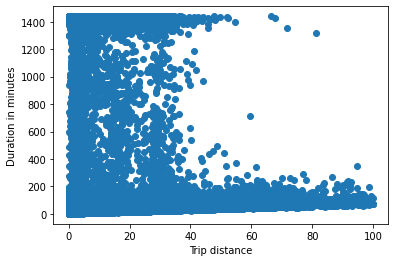

In [90]:
scatter_plot(taxi_data['trip_distance'][(taxi_data["trip_distance"] <= 100)],
             taxi_data['duration'][(taxi_data["trip_distance"] <= 100)],
             'Trip distance', 'Duration in minutes')


##### Na scatter plot-u iznad je pogotovo primjetljivo da za ogromne vrijednosti trajanja (600-1400 min) da je predjena kilometraza svega do 20km

In [99]:
percent = taxi_data['duration'][(taxi_data["duration"] > 600)].count()/taxi_data['duration'].count()*100
print("Procenat voznji cije je trajanje vece od 800min (~13h): ", percent, "%")

Procenat voznji cije je trajanje vece od 800min (~13h):  0.14804869857191322 %


##### Ovim se moze zakljuciti da za sve te ogromne vrijednosti trajanja voznje vozilo bi se kretalo premalim srednjim brzinama
(npr. za duration=600min=10h i trip_distance=10km, avg_speed=1km/h sto je veoma nerealno)
<br>
Iz toga razloga ce se izbaciti sve voznje cije su srednje brzine <=5km/h

In [100]:
taxi_data = taxi_data[(taxi_data["avg_speed"] >5)]

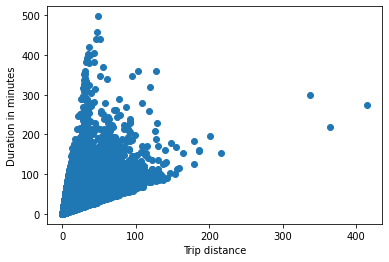

In [101]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

Kao sto smo i prethodno naveli, ove tri tacke koje se nalaze skroz desno nisu nerealne vrijednosti, ali posto su samo tri tacke u pitanju, njih cemo takodje izbaciti, jer nece uticati na konacni rezultat

In [103]:
taxi_data=taxi_data[taxi_data['trip_distance']<250]

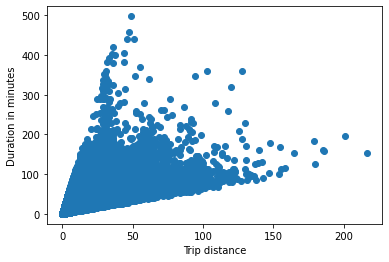

In [104]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

### Fare amount

In [106]:
taxi_data['fare_amount'].describe()

count    1.158410e+07
mean     1.331517e+01
std      1.140100e+01
min      1.000000e-02
25%      6.500000e+00
50%      9.500000e+00
75%      1.550000e+01
max      8.007000e+03
Name: fare_amount, dtype: float64

Nakon sto su izbacene cijene koje su <=0, vidimo da postoji minimalna cijena od 0.01\$. To ne bi trebao da je validan podatak jer se na osnovu istrazivanja cijena taksija (https://www.sciencedirect.com/science/article/pii/S096585642030762X ) za 2016. godinu pocetna cijena 2.5$. 

In [107]:
print('Broj voznji sa cijenom manjom od 2.5$ je: ',taxi_data['fare_amount'][taxi_data['fare_amount']<2.5].count())

Broj voznji sa cijenom manjom od 2.5$ je:  583


Izbacicemo sve voznje cije su cijene manje od 2.5$

In [108]:
taxi_data=taxi_data[taxi_data['fare_amount']>=2.5]

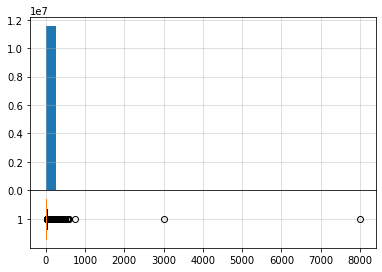

In [109]:
data_distribution(taxi_data['fare_amount'],'fare_amount')

In [110]:
taxi_data[taxi_data['fare_amount']>=600]

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot,duration,avg_speed
654974,1,2,0.4827,5,138,138,2,740.0,2016-05-02,0 days 19:16:07,2016-05-02,0 days 19:17:37,0,workday,Evening,1.500000,19.308000
1923543,1,1,1.6090,5,125,158,3,600.0,2016-05-05,0 days 22:17:26,2016-05-05,0 days 22:21:32,3,workday,Night,4.100000,23.546341
3601104,1,1,2.5744,1,264,264,2,8007.0,2016-05-10,0 days 07:14:37,2016-05-10,0 days 07:22:45,1,workday,Early Morning,8.133333,18.991475
4293380,1,1,2.8962,1,264,264,3,3006.0,2016-05-11,0 days 22:26:52,2016-05-11,0 days 22:32:08,2,workday,Night,5.266667,32.994684


Na osnovu dijagrama i tabele vidimo da postoje autlajeri sa cijenama voznje preko 600\$, pri cemu su one trajale manje od 15min. Takodje postoji i voznja koja je trajala preko 7 sati za razdaljinu od 7km, sto se ne cini kao validan podataka. Ovi autlajeri ce biti izbaceni.

In [111]:
#izbacivanje prethodno prikazanih autlajera
taxi_data=taxi_data[taxi_data['fare_amount']<600]

In [112]:
taxi_data['fare_amount'].describe()

count    1.158351e+07
mean     1.331477e+01
std      1.111827e+01
min      2.500000e+00
25%      6.500000e+00
50%      9.500000e+00
75%      1.550000e+01
max      5.740000e+02
Name: fare_amount, dtype: float64

C:\Users\Srdjan Topic\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

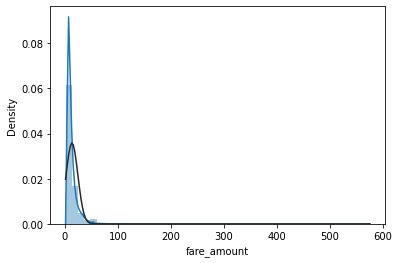

In [113]:
#raspodjela u uporedbi sa normalnom raspodjelom nad skracenim skupom podataka
sb.distplot(taxi_data['fare_amount'], fit=norm)

Iz raspodjele se vidi da je desno asimetricna odnosno i dalje postoji odredjen broj vrijednsoti koje su znatno vece u odnosu na najcesce vrijednosti koje su od 6.5 do 15. (interkvartilni opseg ) . Iz tog razloga je srednja vrijendost od 13. veca od medijana koji je 9.5\$, ali to nije toliko znacajna razlika.

In [116]:
taxi_data['fare_amount'][taxi_data['fare_amount']>200].count()

482

In [117]:
#Izbacivanje voznji sa fare_amount vecim od 200$
taxi_data=taxi_data[taxi_data['fare_amount']<=200]

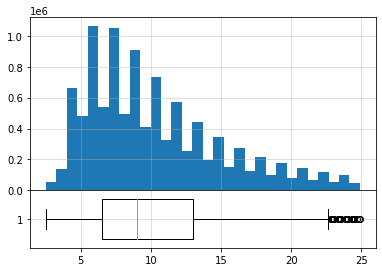

In [118]:
#prikaz distribucije za vrijednosti koje ne predstavljaju potencijalne autlajere (izmedju krajnjih linija)
data_distribution(taxi_data['fare_amount'][taxi_data['fare_amount']<25],'fare_amount')

<h3> Kombinacija cijene sa razdaljinom i cijene sa trajanjem </h3>

Text(0, 0.5, 'duration')

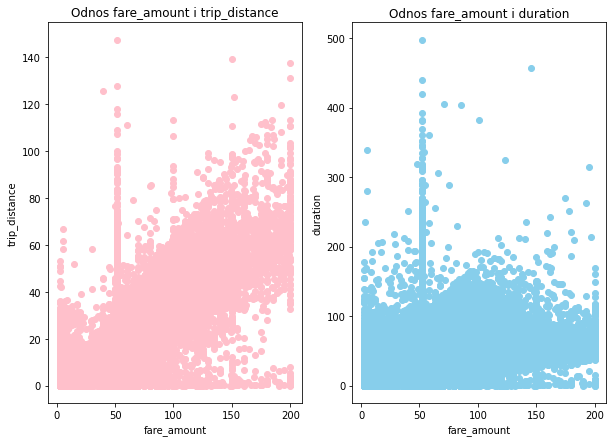

In [119]:
#uporedjivanje
fig, ax = plt.subplots(1,2,figsize=(10,7))
ax[0].scatter(taxi_data['fare_amount'],taxi_data['trip_distance'], color='pink')
ax[0].set_title('Odnos fare_amount i trip_distance')
ax[1].scatter(taxi_data['fare_amount'],taxi_data['duration'], color='skyblue')
ax[1].set_title('Odnos fare_amount i duration')

ax[0].set_xlabel('fare_amount')
ax[0].set_ylabel('trip_distance')
ax[1].set_xlabel('fare_amount')
ax[1].set_ylabel('duration')

Moze se primjetiti da postoji veliki broj voznji koje imaju mali trip_distance(manje od 1km)za fare_amount preko 20. Takodje isto vazi i za trajanje voznje gdje se neke naplacuju vise od 20$ a nisu trajale ni minut

Pored toga mogu se primjetiti i nevalidni podacci koji idu u drugu krajnost odnosno da su voznje za preko 40km i koju su trajale vise od 3h naplacivane manje od 5$

In [120]:
print('Broj obiljezja u preciscenom dataset-u: ',taxi_data.shape[0])

Broj obiljezja u preciscenom dataset-u:  11583030


In [123]:
#Cuvanje preciscenjih podataka u odvojen csv
taxi_data.to_parquet('yellow_tripdata_2016-05_CLEANED.parquet')